In [2]:
import statsmodels.tsa.stattools as smtst
import statsmodels.stats.diagnostic as smsd
import statsmodels.api as sm

import pandas as pd
import numpy as np
import scipy as sc
import math as mt

import matplotlib.pyplot as pt
from matplotlib.patches import Rectangle
import seaborn as sns
from tabulate import tabulate
from IPython.display import HTML, display

from sklearn.base import BaseEstimator, ClassifierMixin
import sklearn.preprocessing as preprocessing
import sklearn.svm as svm
from sklearn.linear_model import LinearRegression, SGDClassifier, RidgeClassifierCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RandomizedLogisticRegression
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import make_scorer, roc_auc_score, confusion_matrix, auc, roc_curve, accuracy_score

from datetime import datetime
import sys

In [3]:
def roc_auc_calc(y, y_pred):
    roc_auc = roc_auc_score(y_true = y, y_score = y_pred)
    return (max(roc_auc, (1-roc_auc)))
roc_auc_scorer = make_scorer(roc_auc_calc, greater_is_better=True)

In [4]:
tscv = TimeSeriesSplit(n_splits = 5)

######  

# 1.1. Exploratory data analysis

In [5]:
data = pd.read_csv('marketdata.csv')
data['date_'] = data['date_'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())

## Analysis of S&P 500 returns

### Time series

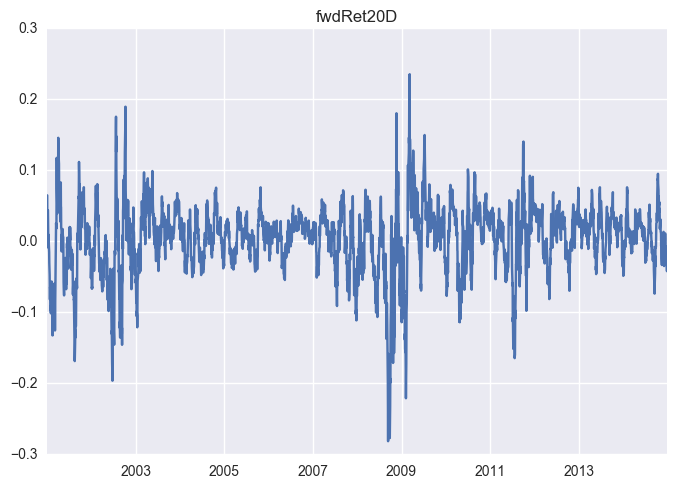

In [6]:
fg = pt.figure()
ax = fg.add_subplot(1,1,1)
ax.plot(data['date_'], data['fwdRet20D'])
ax.set_title('fwdRet20D')
pt.show()

##### The chart suggests a presence of heteroskedasticity

### Histogram

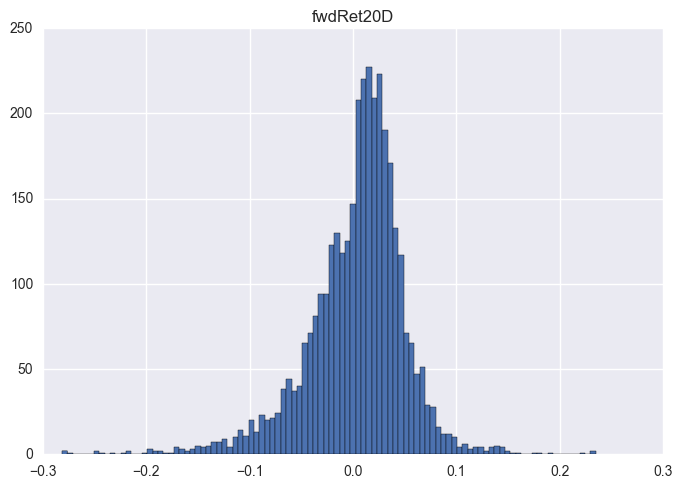

In [7]:
fg = pt.figure()
ax = fg.add_subplot(1,1,1)
ax.hist(data['fwdRet20D'], bins=100)
ax.set_title('fwdRet20D')
pt.show()

##### Distribution of S&P 500 returns does not look normal because of high kurtosis

### Augmented Dickey–Fuller test of stationarity

In [8]:
adf = smtst.adfuller(data['fwdRet20D'])
print('ADF Statistic: %f' % adf[0])
print('p-value: %f' % adf[1])
print('Critical Values:')
for key, value in adf[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -9.184916
p-value: 0.000000
Critical Values:
	10%: -2.567
	1%: -3.432
	5%: -2.862


##### ADF test does not reject stationarity

### Breusch-Pagan test of stationarity

In [9]:
dflmx = pd.DataFrame(data['fwdRet20D'])[:-1]
dflmx['t'] = dflmx.index
dflmy = pd.DataFrame(data['fwdRet20D'])[1:]
tlm = LinearRegression(fit_intercept=True)
tlm.fit(dflmx, dflmy)
resid = (dflmy - tlm.predict(dflmx))
bpt = smsd.het_breushpagan(resid = resid, exog_het=dflmx)
print('F-statistic: %f' % bpt[2])
print('p-value: %f' % bpt[3])

F-statistic: 179.187359
p-value: 0.000000


##### BP test also does not reject stationarity

### Autocorrelation function

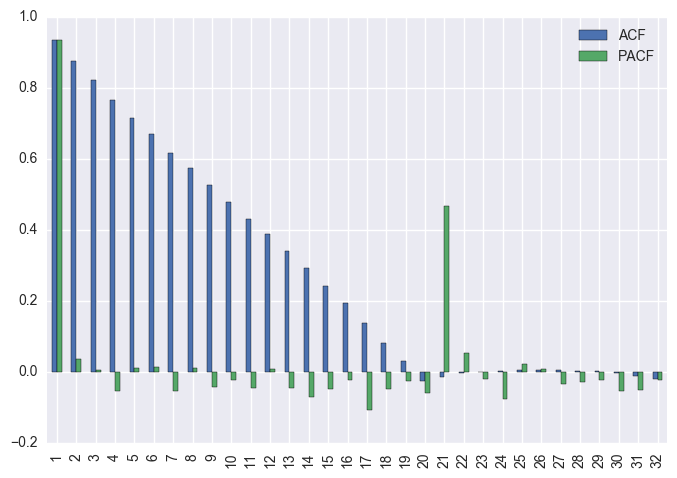

In [10]:
acf = smtst.acf(data['fwdRet20D'])[1:33]
pacf = smtst.pacf(data['fwdRet20D'])[1:33]

cfs = pd.DataFrame([acf, pacf]).T
cfs.columns = ['ACF', 'PACF']
cfs.index += 1

cfs.plot(kind='bar')
pt.show()

##### Autocorrelation of 1st-20th orders is technical, since S&P returns are aggregated over a 20-day period. Hovewer, there is an evidence of autocorrelation of 21st order. Thus, 21-st lag of the S&P returns can be included into the list of features.

##### Overall, non-normality of distribution and presence of heteroskedasticity suggest that statistical models may be not efficient for prediction of S&P 500 returns. Thus, ML models might provide a better result.

## Analysis of features

### Time series

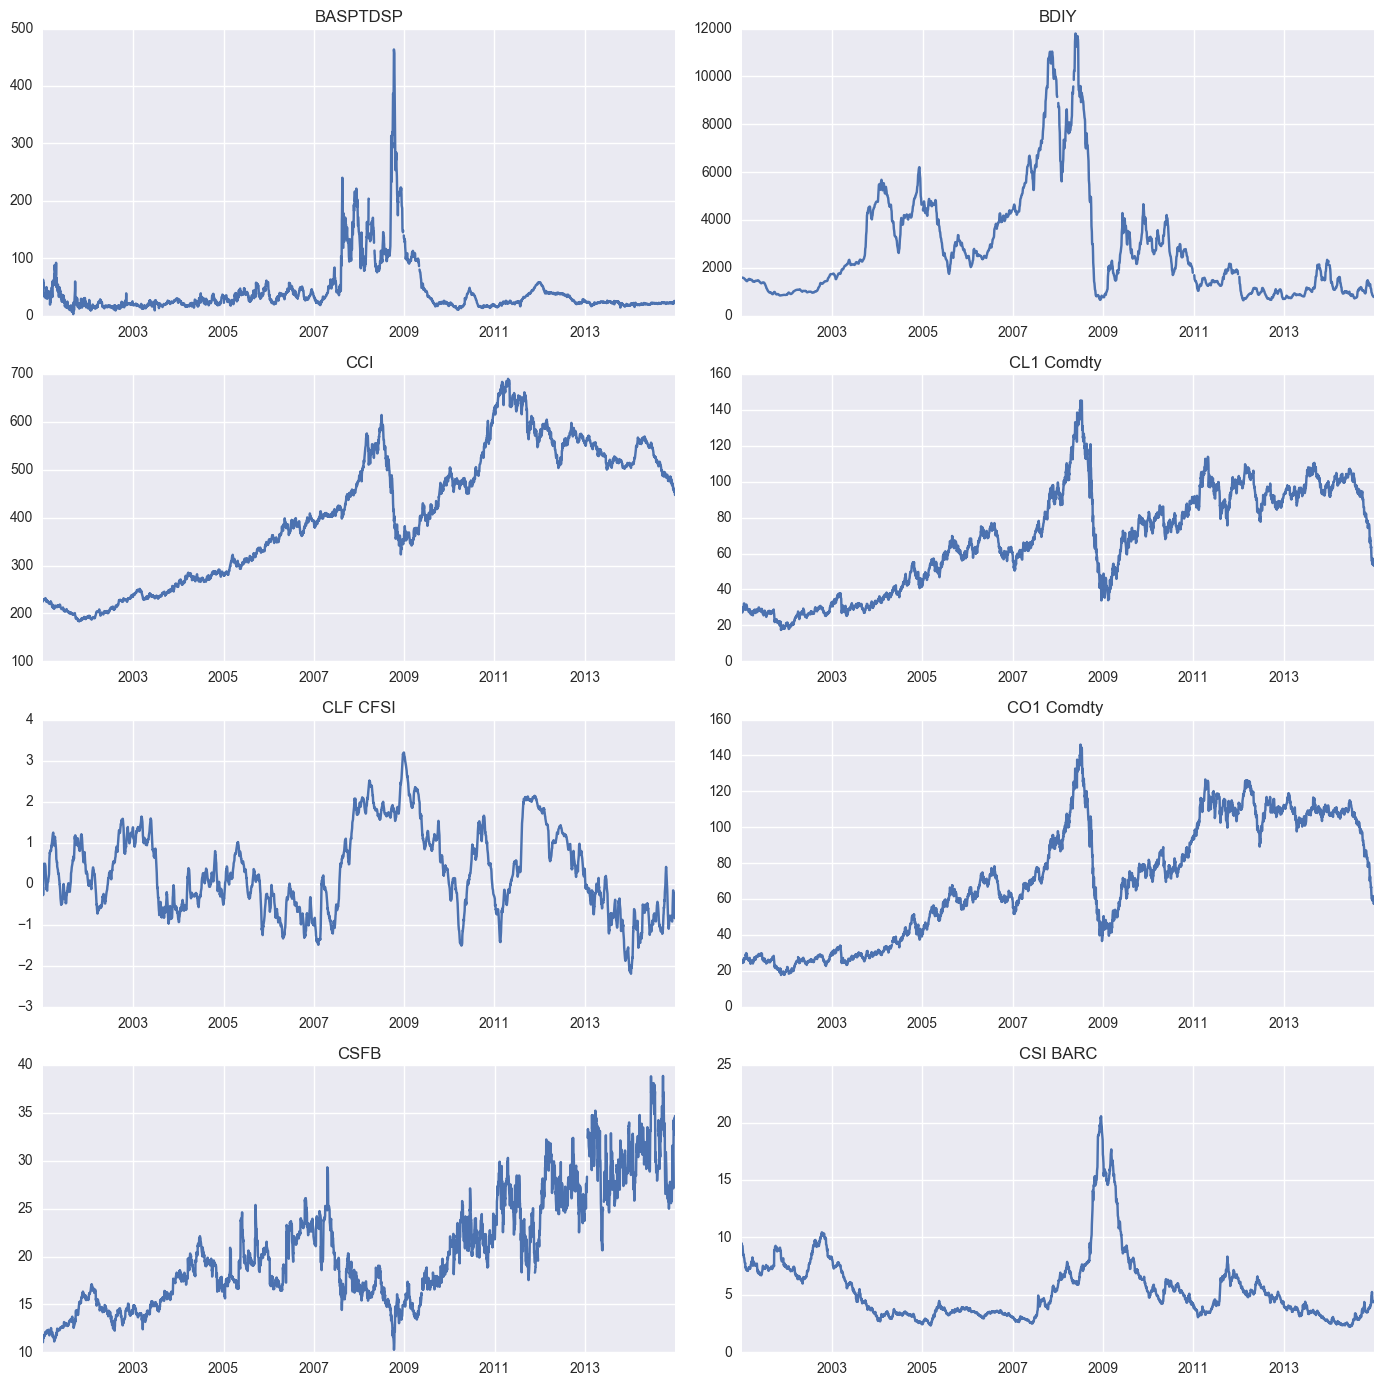

In [11]:
Variables = list(data)
Variables.remove('fwdRet20D')
Variables.remove('DOY')
fg = pt.figure(figsize=(14,14))
for i in range(1,len(Variables[:9])):
    ax = fg.add_subplot(mt.floor(len(Variables[:9])/2),2,i)
    ax.plot(data['date_'], data[Variables[i]])
    ax.set_title(Variables[i])
pt.tight_layout()
pt.show()

##### Some features exhibit a strong deterministic trend, as well as heteroscedasticity.

### Histograms

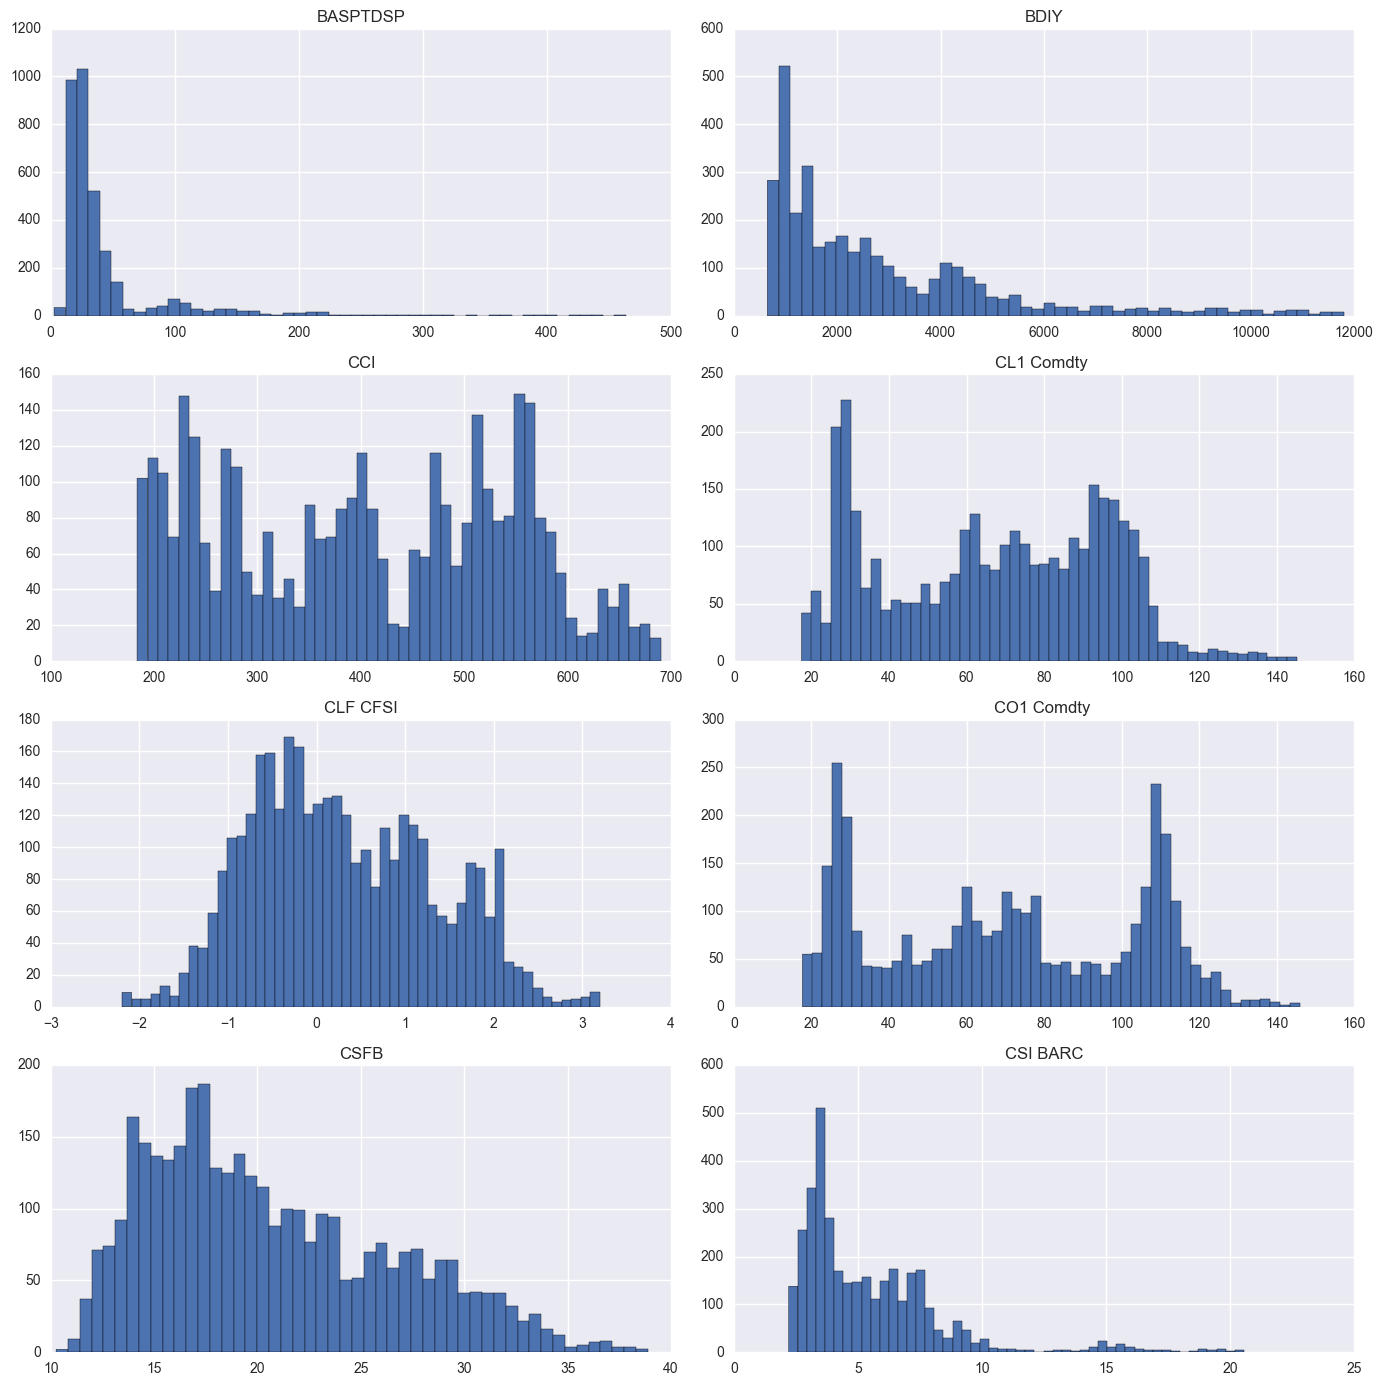

In [12]:
fg = pt.figure(figsize=(14,14))
for i in range(1,len(Variables[:9])):
    ax = fg.add_subplot(mt.floor(len(Variables[:9])/2),2,i)
    ax.hist(data[Variables[i]].dropna(axis=0, how='any'), bins=50)
    ax.set_title(Variables[i])
pt.tight_layout()
pt.show()

##### Many features have a skewed distribution due to non-stationarity.

### Augmented Dickey–Fuller test of stationarity

In [17]:
table = [['Variable name', 'ADF Statistic', 'p-value']]
for i in range(1, len(Variables)):
    adf = smtst.adfuller(data[Variables[i]].dropna(axis=0, how='any'))
    table.append([Variables[i], round(adf[0],4), round(adf[1],4)])
display(HTML(tabulate(table, tablefmt='html')))

Variable name,ADF Statistic,p-value
BASPTDSP,-3.3682,0.0121
BDIY,-2.4994,0.1156
CCI,-1.3436,0.609
CL1 Comdty,-1.7433,0.409
CLF CFSI,-3.1643,0.0221
CO1 Comdty,-1.6109,0.4775
CSFB,-1.9897,0.2911
CSI BARC,-2.4904,0.1178
DXY Curncy,-1.8246,0.3683
GFSI,-3.6499,0.0049


##### ADF test further confirm that many features are not stationary, so they need to be transformed.

### F-test of weekly seasonality

In [18]:
table = [['Variable name', 'F-statistic', 'p-value']]
for i in range(1,len(Variables)):
    VarData = data[['date_',Variables[i]]].dropna(axis=0, how='any')
    WeeklyData = VarData['date_'].apply(lambda x: x.isocalendar()[1])
    Dummies = pd.get_dummies(WeeklyData)
    xlm = sm.add_constant(Dummies)
    est = sm.OLS(VarData[Variables[i]], xlm).fit()
    table.append([Variables[i], round(est.fvalue,4), round(est.f_pvalue,4)])
display(HTML(tabulate(table, tablefmt='html')))

Variable name,F-statistic,p-value
BASPTDSP,1.8478,0.0002
BDIY,0.3671,1.0
CCI,0.0739,1.0
CL1 Comdty,0.7178,0.9366
CLF CFSI,0.9446,0.5876
CO1 Comdty,0.5942,0.9909
CSFB,0.5019,0.9989
CSI BARC,0.7744,0.8804
DXY Curncy,0.2695,1.0
GFSI,0.8336,0.7967


##### Weakly seasonality may also be a problem for some features.

######  

# 1.2. Cleaning and transforming data

### Log-difference transformation

In [19]:
TransData = data.copy()
Transform_exceptions = ['GSERMAJ', 'GSERMEA', 'GSERMUS', 'GSERMWD', 'SPX CURRENT_EV_TO_T12M_EBITDA', 'SPX PE_RATIO',
                        'SPX RSI_14D', 'SPX RSI_30D', 'SPX RSI_9D']
for i in range(2, len(Variables)):
    if (Variables[i] not in Transform_exceptions):
        CenteredVar = data[Variables[i]].apply(lambda x: x + 1 - np.min(data[Variables[i]]))
        LogDiff = np.log(CenteredVar) - np.log(CenteredVar.shift(1))
        TransData[Variables[i]] = LogDiff.copy()

### Removing weekly seasonality

In [20]:
TransData2 = TransData.copy()
for i in range(1,len(Variables)):
    VarData = TransData2[['date_',Variables[i]]].dropna(axis=0, how='any')
    VarData['Week'] = VarData['date_'].apply(lambda x: x.isocalendar()[1])
    Dummies = pd.get_dummies(VarData['Week'])
    xlm = sm.add_constant(Dummies[Dummies.columns[:-1]])
    est = sm.OLS(VarData[Variables[i]], xlm).fit()
    if (est.f_pvalue < 0.01):
        TransData2[Variables[i]] = est.resid + est.params[0]

### Dropping severe outliers and missing values

In [21]:
TransData3 = TransData2.copy()
TransData3['fwdRet20DLag21'] = TransData3['fwdRet20D'].shift(21).copy()
Variables3 = list(Variables)
Variables3.append('fwdRet20DLag21')

for i in range(1,len(Variables3)):
    avg = np.mean(TransData3[Variables3[i]])
    stdev = np.std(TransData3[Variables3[i]])
    TransData3.loc[abs(TransData3[Variables3[i]] - avg) > 5*stdev, Variables3[i]] = np.nan
    
TransData3 = TransData3.dropna(axis=0, how='any')

### Spliting data into training and test sets

In [22]:
TestSet_size = 250
Bound = len(TransData3) - TestSet_size
BoundDate = TransData3['date_'].iloc[Bound]
TrainSet = TransData3.iloc[:Bound]
TestSet = TransData3.iloc[Bound:]

### Standardization of training set

In [23]:
TrainSetS = TrainSet.copy()
scaler = preprocessing.StandardScaler()
TrainSetS[Variables3[1:]] = scaler.fit_transform(TrainSetS[Variables3[1:]])

### Histograms of preprocessed training set

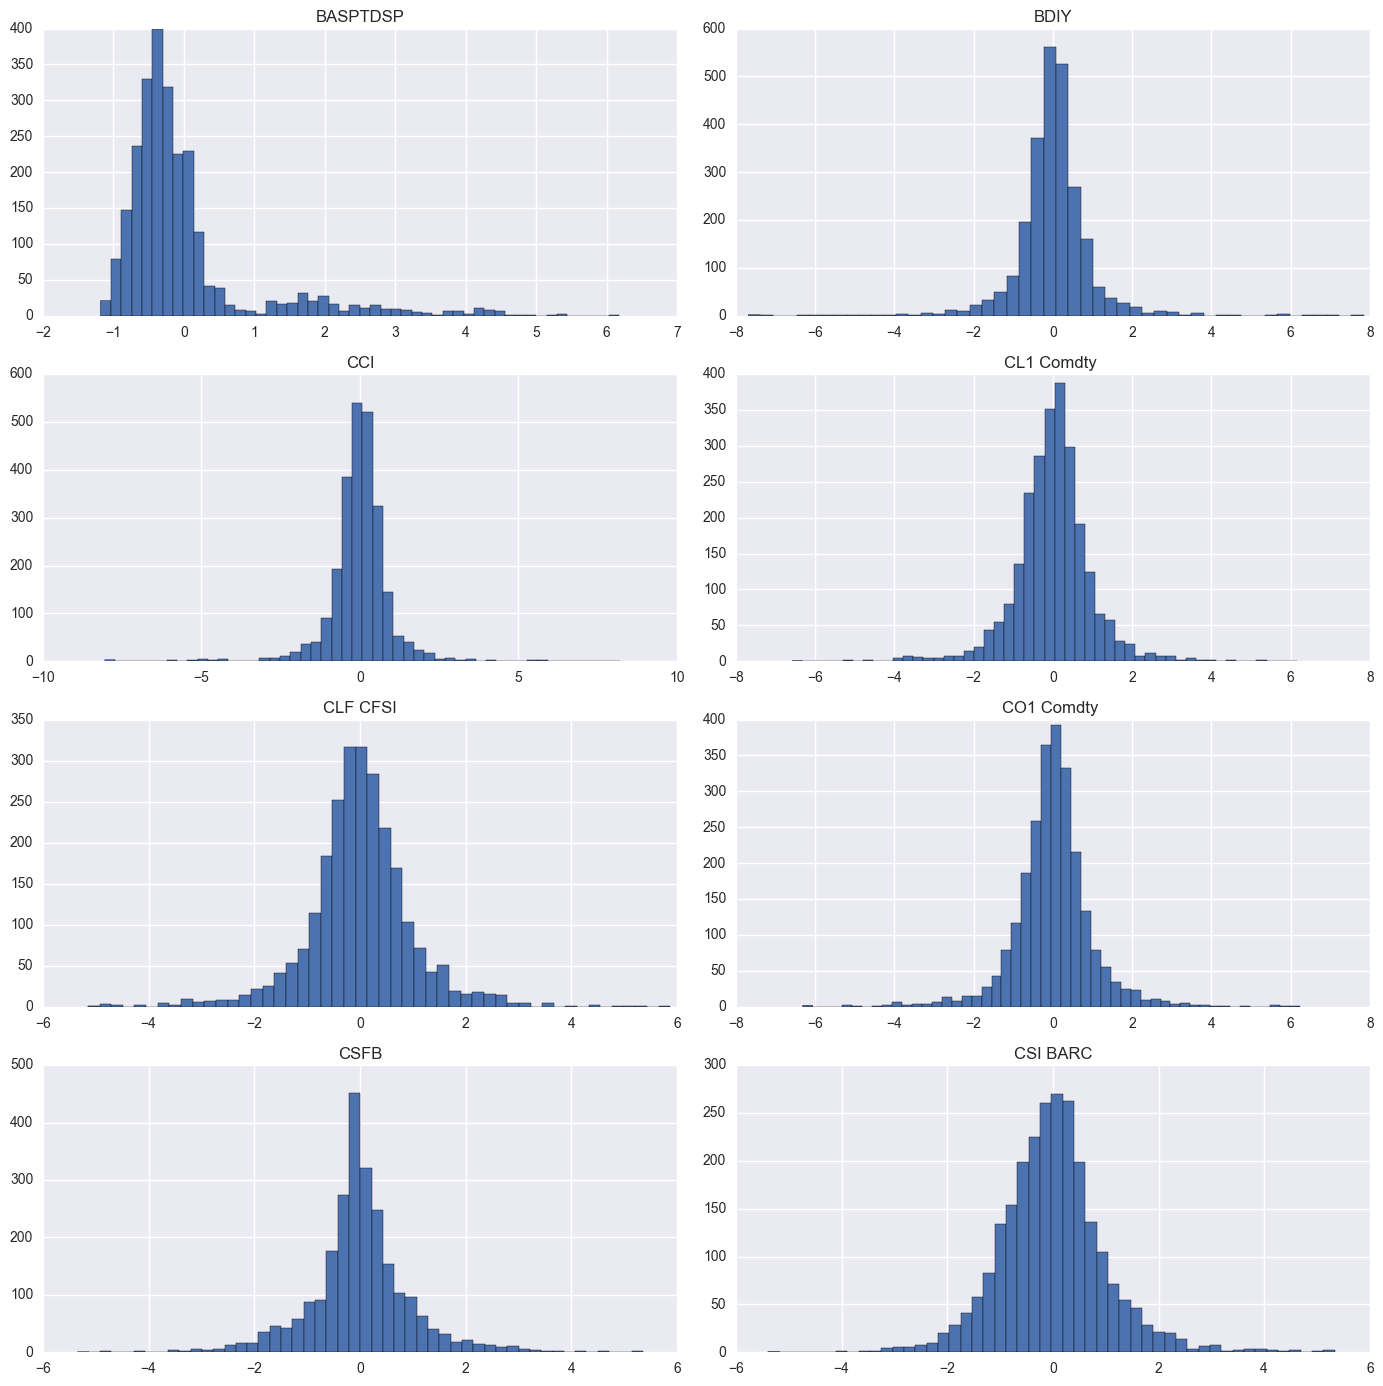

In [24]:
fg = pt.figure(figsize=(14,14))
for i in range(1,len(Variables3[:9])):
    ax = fg.add_subplot(mt.floor(len(Variables3[:9])/2),2,i)
    ax.hist(TrainSetS[Variables3[i]].dropna(axis=0, how='any'), bins=50)
    ax.set_title(Variables3[i])
pt.tight_layout()
pt.show()

##### Preprocessed features now have better distribution shapes.

######  

# 1.3. Feature selection

### Dimensionality reduction with PCA

In [28]:
Xvar = TrainSetS[Variables3[1:]]
Yvar = np.sign(TrainSetS['fwdRet20D'])
pca = PCA(n_components=20, svd_solver='full')
pca.fit(Xvar)
print('Explained portion of variance:')
np.round(np.cumsum(pca.explained_variance_ratio_), 2)

Explained portion of variance:


array([ 0.23,  0.28,  0.33,  0.38,  0.41,  0.45,  0.48,  0.5 ,  0.52,
        0.54,  0.56,  0.58,  0.6 ,  0.61,  0.63,  0.65,  0.66,  0.67,
        0.69,  0.7 ])

##### Unfortunately, first 20 principal components explain just 70% of variation in the data. Thus, dimensionality reduction exercise is not helpful.

### Feature selection with recursive feature elimination and cross-validation

##### RFECV method is used to drop redundant features

In [32]:
RankThreshold = len(Xvar.columns)/2
LogReg = LogisticRegression(C = 4.5, penalty='l1', class_weight = 'balanced')
select_RFECV = RFECV(estimator = LogReg, cv=tscv, scoring = roc_auc_scorer)
selector = select_RFECV.fit(Xvar, Yvar)
SelectedFeatures = []
for i in range(0,len(selector.ranking_)):
    if (selector.ranking_[i] <= RankThreshold):
        SelectedFeatures.append(Xvar.columns[i])
print('Number of pre-selected features:', len(SelectedFeatures))

Number of pre-selected features: 40


### Feature selection with stability selection method

##### Stability selection method selects the most relevant features based on importance score

In [33]:
Xvar2 = Xvar[SelectedFeatures]
Yvar2 = Yvar
RLR_selector = RandomizedLogisticRegression(C = 4.5, sample_fraction = 0.5, n_resampling = 10000)
RLR = RLR_selector.fit(Xvar2, Yvar2)
SelectedFeatures2 = []
selector_support = RLR.get_support()
for i in range(0,len(Xvar2.columns)):
    if (selector_support[i]):
        SelectedFeatures2.append(Xvar2.columns[i])
print('Selected features:')
SelectedFeatures2

Selected features:


['BASPTDSP',
 'BDIY',
 'CCI',
 'CLF CFSI',
 'CO1 Comdty ',
 'GFSI',
 'GSERMAJ',
 'GSERMEA',
 'GSERMUS',
 'IBOXHY',
 'IRISISOL',
 'MRI CITI',
 'MRI ST',
 'RLABVPTU',
 'SPX Index BEST_EPS',
 'SPX Index MOV_AVG_20D',
 'SPX Index MOV_AVG_50D',
 'SPX Index PCT_MEMB_PX_GT_50D_MOV_AVG',
 'TRADCANY',
 'USGG10YR',
 'VOLSPX Index MOV_AVG_20D',
 'VOLSPX Index MOV_AVG_50D',
 'VOLSPX']

######  

# 1.4. Preventing overfitting

##### Several techniques are used throughout the project to prevent overfitting:
##### 1. Cross validation. First, the dataset is split into a training set and test set at approximately 90% / 10% proportion. Then, the training dataset is further split into smaller training and validation sets so that each model is trained on a training set, but its score is calculated on a validation set.
##### 2. Bagging/Boosting. The training set is split into 5 subsamples of different length and each model’s score is calculated as average score across these subsamples. In addition, some models, such as random forest or randomized logistic regression, apply a bagging technique during training.
##### 3. Regularization. Many models allow to explicitly specify regularization parameters that penalize the model for excessively high coefficients.
##### 4. Class balancing. Classes in the training dataset are weighted according to their frequencies.
##### 5. Using AUC metrics to compare models and estimate hyper-parameters. These types of metrics are independent of class distribution in a particular dataset.

######  

# 1.5. Model evaluation criteria

##### Since the costs of false positives and false negatives are equal for the developed trading strategy, the ultimate goal of creating an ML model is to maximize the accuracy rate. In particular, the accuracy rate should be at least as high as that of a passive long position, since taking such a position would be the best strategy if no features were available.
##### However, comparing different ML models to each other based on accuracy rate is not a good approach, as accuracy rate represents just a single point on the ROC curve, and so depends on class distribution in the dataset. A better approach is to use an AUC metric, which is robust to changes in class distribution. The same is true for hyper-parameters estimation: they should be selected to maximize an AUC metric. A good scoring metric for the developed trading strategy is ROC AUC, as maximizing ROC AUC implies maximizing both true positive rate and true negative rate at the same time.
##### When the best model has been selected and its hyper-parameters has been estimated to maximize its ROC AUC, the accuracy rate of a model can be optimized by choosing the best probability threshold for classification rule. I extend the base class of a classifier to include the option of specifying the probability threshold and use it for making predictions.
##### Some other considerations in model evaluation include standard error of the scoring metric and algorithm complexity.

######  

# 1.6. Determining parameters for machine learning methods

##### Hyper-parameters of machine learning models are primarily estimated through an exhaustive grid search with cross validation on the training dataset. The scoring function is ROC AUC.
##### Some models allow for a model specific parameter estimation with cross validation, which is typically a faster method than a grid search. In this case, this method is used instead of a grid search.
##### On the last step, when the best model has been selected and its hyper-parameters has been estimated to maximize ROC AUC, I choose the probability threshold for classification rule in order to maximize the model’s accuracy rate. This threshold is also selected through a grid search with cross-validation, similarly to hyper-parameters estimation.

######  

# 2. Implementing machine learning models

### Dropping unselected features

In [34]:
TransData3N = TransData2.copy()
TransData3N['fwdRet20DLag21'] = TransData3N['fwdRet20D'].shift(21).copy()
Variables3N = ['date_', 'fwdRet20D', 'DOY'] + SelectedFeatures2
TransData3N = TransData3N[Variables3N]

TestSetN = TransData3N[TransData3N['date_'] >= BoundDate].copy()
TestSetN = TestSetN.dropna(axis=0, how='any')

for i in range(1,len(SelectedFeatures2)):
    avg = np.mean(TransData3N[SelectedFeatures2[i]])
    stdev = np.std(TransData3N[SelectedFeatures2[i]])
    TransData3N.loc[abs(TransData3N[SelectedFeatures2[i]] - avg) > 5*stdev, SelectedFeatures2[i]] = np.nan
TrainSetN = TransData3N[TransData3N['date_'] < BoundDate].copy()
TrainSetN = TrainSetN.dropna(axis=0, how='any')

TrainSetNS = TrainSetN.copy()
TestSetNS = TestSetN[['date_', 'DOY']].copy()
for colname in ['fwdRet20D'] + SelectedFeatures2:
    avg = np.mean(TrainSetN[colname])
    stdev = np.std(TrainSetN[colname])
    TestSetNS[colname] = (TestSetN[colname] - avg) / stdev
scaler = preprocessing.StandardScaler()
TrainSetNS[['fwdRet20D'] + SelectedFeatures2] = scaler.fit_transform(TrainSetN[['fwdRet20D'] + SelectedFeatures2])

Yvar3 = np.sign(TrainSetNS['fwdRet20D'])
Xvar3 = TrainSetNS[SelectedFeatures2]

### Parameters estimation for Logistic Regression Classifier

Best ROC AUC score is 0.546 (+/-0.022). Best parameter found on development set:
C = 21.544


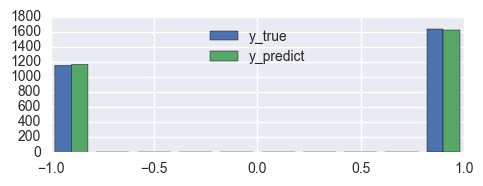

In [36]:
clf = LogisticRegressionCV(cv = tscv, scoring = roc_auc_scorer, class_weight = 'balanced')
clf.fit(Xvar3, Yvar3)
scores = cross_val_score(estimator = clf, X = Xvar3, y = Yvar3, cv=tscv, scoring = roc_auc_scorer)
print("Best ROC AUC score is %0.3f (+/-%0.03f)." % (scores.mean(), scores.std()), "Best parameter found on development set:")
print("C = %0.3f" % clf.C_[0])

lr_best_params = clf.get_params()
y_true, y_predict = Yvar3, clf.predict(Xvar3)
fg = pt.figure(figsize=(5,2))
pt.hist([y_true, y_predict])
pt.legend(labels = ['y_true', 'y_predict'], loc = 9)
pt.tight_layout()
pt.show()

### Parameters estimation for Support Vector Machine Classifier

Grid ROC AUC scores on development set:
0.541 (+/-0.027) for {'coef0': -0.02, 'gamma': 0.04, 'C': 9.5}
0.563 (+/-0.033) for {'coef0': -0.02, 'gamma': 0.05, 'C': 9.5}
0.563 (+/-0.033) for {'coef0': -0.02, 'gamma': 0.05, 'C': 9.5}
0.536 (+/-0.019) for {'coef0': -0.01, 'gamma': 0.04, 'C': 9.5}
0.568 (+/-0.036) for {'coef0': -0.01, 'gamma': 0.05, 'C': 9.5}
0.568 (+/-0.036) for {'coef0': -0.01, 'gamma': 0.05, 'C': 9.5}
0.532 (+/-0.012) for {'coef0': 0, 'gamma': 0.04, 'C': 9.5}
0.564 (+/-0.033) for {'coef0': 0, 'gamma': 0.05, 'C': 9.5}
0.564 (+/-0.033) for {'coef0': 0, 'gamma': 0.05, 'C': 9.5}
0.539 (+/-0.022) for {'coef0': -0.02, 'gamma': 0.04, 'C': 10}
0.563 (+/-0.030) for {'coef0': -0.02, 'gamma': 0.05, 'C': 10}
0.563 (+/-0.030) for {'coef0': -0.02, 'gamma': 0.05, 'C': 10}
0.539 (+/-0.017) for {'coef0': -0.01, 'gamma': 0.04, 'C': 10}
0.588 (+/-0.016) for {'coef0': -0.01, 'gamma': 0.05, 'C': 10}
0.588 (+/-0.016) for {'coef0': -0.01, 'gamma': 0.05, 'C': 10}
0.540 (+/-0.026) for {'coef0': 0,

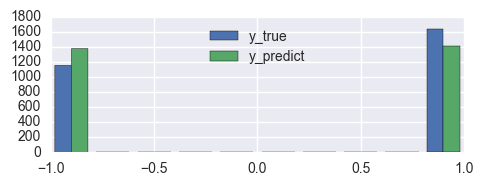

In [71]:
estm = svm.SVC(kernel = 'sigmoid', class_weight = 'balanced')
tuned_parameters = [{'C': [9.5, 10, 10.5], 'gamma': [0.04, 0.05, 0.05], 'coef0': [-0.02, -0.01, 0]}]

clf = GridSearchCV(estimator=estm, param_grid=tuned_parameters, cv=tscv, scoring=roc_auc_scorer)
clf.fit(Xvar3, Yvar3)

print("Grid ROC AUC scores on development set:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
        % (mean, std, params))
print()
print("Best ROC AUC score is %0.3f." % clf.best_score_, "Best parameters set found on development set:")
print(clf.best_params_)

svm_best_params = clf.best_params_
estm.set_params(**svm_best_params)
estm.fit(Xvar3, Yvar3)
y_true, y_predict = Yvar3, estm.predict(Xvar3)
fg = pt.figure(figsize=(5,2))
pt.hist([y_true, y_predict])
pt.legend(labels = ['y_true', 'y_predict'], loc = 9)
pt.tight_layout()
pt.show()

### Parameters estimation for K-Neighbors Classifier

Grid ROC AUC scores on development set:
0.528 (+/-0.012) for {'weights': 'uniform', 'n_neighbors': 1}
0.528 (+/-0.012) for {'weights': 'distance', 'n_neighbors': 1}
0.526 (+/-0.017) for {'weights': 'uniform', 'n_neighbors': 2}
0.528 (+/-0.012) for {'weights': 'distance', 'n_neighbors': 2}
0.518 (+/-0.019) for {'weights': 'uniform', 'n_neighbors': 3}
0.518 (+/-0.019) for {'weights': 'distance', 'n_neighbors': 3}
0.522 (+/-0.017) for {'weights': 'uniform', 'n_neighbors': 5}
0.522 (+/-0.017) for {'weights': 'distance', 'n_neighbors': 5}
0.517 (+/-0.015) for {'weights': 'uniform', 'n_neighbors': 10}
0.515 (+/-0.015) for {'weights': 'distance', 'n_neighbors': 10}
0.513 (+/-0.010) for {'weights': 'uniform', 'n_neighbors': 100}
0.513 (+/-0.012) for {'weights': 'distance', 'n_neighbors': 100}
0.506 (+/-0.008) for {'weights': 'uniform', 'n_neighbors': 300}
0.504 (+/-0.005) for {'weights': 'distance', 'n_neighbors': 300}

Best ROC AUC score is 0.528. Best parameters set found on development set:

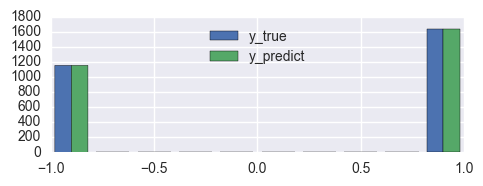

In [44]:
estm = KNeighborsClassifier()
tuned_parameters = [{'weights': ['uniform','distance'], 'n_neighbors': [1, 2, 3, 5, 10, 100, 300]}]

clf = GridSearchCV(estimator=estm, param_grid=tuned_parameters, cv=tscv, scoring=roc_auc_scorer)
clf.fit(Xvar3, Yvar3)

print("Grid ROC AUC scores on development set:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
        % (mean, std, params))
print()
print("Best ROC AUC score is %0.3f." % clf.best_score_, "Best parameters set found on development set:")
print(clf.best_params_)

knn_best_params = clf.best_params_
estm.set_params(**knn_best_params)
estm.fit(Xvar3, Yvar3)
y_true, y_predict = Yvar3, estm.predict(Xvar3)
fg = pt.figure(figsize=(5,2))
pt.hist([y_true, y_predict])
pt.legend(labels = ['y_true', 'y_predict'], loc = 9)
pt.tight_layout()
pt.show()

### Parameters estimation for Stochastic Gradient Descent Classifier

Grid ROC AUC scores on development set:
0.555 (+/-0.039) for {'alpha': 0.4, 'l1_ratio': 0}
0.554 (+/-0.029) for {'alpha': 0.4, 'l1_ratio': 0.1}
0.581 (+/-0.046) for {'alpha': 0.4, 'l1_ratio': 0.2}
0.573 (+/-0.046) for {'alpha': 0.4, 'l1_ratio': 0.3}
0.557 (+/-0.047) for {'alpha': 0.4, 'l1_ratio': 0.5}
0.500 (+/-0.000) for {'alpha': 0.4, 'l1_ratio': 1}
0.556 (+/-0.038) for {'alpha': 0.41, 'l1_ratio': 0}
0.553 (+/-0.033) for {'alpha': 0.41, 'l1_ratio': 0.1}
0.581 (+/-0.054) for {'alpha': 0.41, 'l1_ratio': 0.2}
0.575 (+/-0.043) for {'alpha': 0.41, 'l1_ratio': 0.3}
0.544 (+/-0.049) for {'alpha': 0.41, 'l1_ratio': 0.5}
0.500 (+/-0.000) for {'alpha': 0.41, 'l1_ratio': 1}
0.555 (+/-0.039) for {'alpha': 0.42, 'l1_ratio': 0}
0.553 (+/-0.034) for {'alpha': 0.42, 'l1_ratio': 0.1}
0.583 (+/-0.051) for {'alpha': 0.42, 'l1_ratio': 0.2}
0.574 (+/-0.043) for {'alpha': 0.42, 'l1_ratio': 0.3}
0.532 (+/-0.044) for {'alpha': 0.42, 'l1_ratio': 0.5}
0.500 (+/-0.000) for {'alpha': 0.42, 'l1_ratio': 1}
0.557 

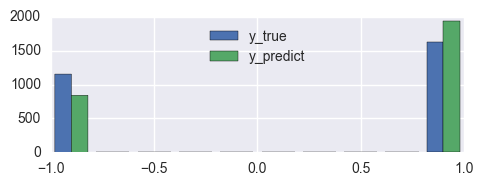

In [132]:
estm = SGDClassifier(loss = 'modified_huber', penalty='elasticnet', shuffle = False, n_iter = 100, class_weight = 'balanced')
tuned_parameters = [{'alpha': [0.4, 0.41, 0.42, 0.43, 0.44], 'l1_ratio': [0, 0.1, 0.2, 0.3, 0.5, 1]}]

clf = GridSearchCV(estimator=estm, param_grid=tuned_parameters, cv=tscv, scoring=roc_auc_scorer)
clf.fit(Xvar3, Yvar3)

print("Grid ROC AUC scores on development set:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
        % (mean, std, params))
print()
print("Best ROC AUC score is %0.3f." % clf.best_score_, "Best parameters set found on development set:")
print(clf.best_params_)

sgd_best_params = clf.best_params_
estm.set_params(**sgd_best_params)
estm.fit(Xvar3, Yvar3)
y_true, y_predict = Yvar3, estm.predict(Xvar3)
fg = pt.figure(figsize=(5,2))
pt.hist([y_true, y_predict])
pt.legend(labels = ['y_true', 'y_predict'], loc = 9)
pt.tight_layout()
pt.show()

### Parameters estimation for Gradient Boosting Classifier

Grid ROC AUC scores on development set:
0.530 (+/-0.049) for {'max_depth': 1, 'learning_rate': 3.05}
0.575 (+/-0.065) for {'max_depth': 2, 'learning_rate': 3.05}
0.542 (+/-0.039) for {'max_depth': 3, 'learning_rate': 3.05}
0.548 (+/-0.026) for {'max_depth': 5, 'learning_rate': 3.05}
0.530 (+/-0.049) for {'max_depth': 1, 'learning_rate': 3.15}
0.582 (+/-0.062) for {'max_depth': 2, 'learning_rate': 3.15}
0.528 (+/-0.024) for {'max_depth': 3, 'learning_rate': 3.15}
0.558 (+/-0.053) for {'max_depth': 5, 'learning_rate': 3.15}
0.533 (+/-0.047) for {'max_depth': 1, 'learning_rate': 3.25}
0.594 (+/-0.050) for {'max_depth': 2, 'learning_rate': 3.25}
0.534 (+/-0.021) for {'max_depth': 3, 'learning_rate': 3.25}
0.527 (+/-0.014) for {'max_depth': 5, 'learning_rate': 3.25}
0.533 (+/-0.047) for {'max_depth': 1, 'learning_rate': 3.35}
0.544 (+/-0.021) for {'max_depth': 2, 'learning_rate': 3.35}
0.547 (+/-0.034) for {'max_depth': 3, 'learning_rate': 3.35}
0.571 (+/-0.024) for {'max_depth': 5, 'learni

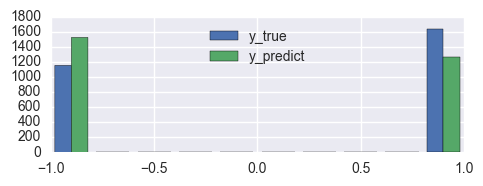

In [134]:
estm = GradientBoostingClassifier(n_estimators = 50)
tuned_parameters = [{'learning_rate': [3.05, 3.15, 3.25, 3.35, 3.45], 'max_depth': [1, 2, 3, 5]}]

clf = GridSearchCV(estimator=estm, param_grid=tuned_parameters, cv=tscv, scoring=roc_auc_scorer)
clf.fit(Xvar3, Yvar3)

print("Grid ROC AUC scores on development set:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
        % (mean, std, params))
print()
print("Best ROC AUC score is %0.3f." % clf.best_score_, "Best parameters set found on development set:")
print(clf.best_params_)

gb_best_params = clf.best_params_
estm.set_params(**gb_best_params)
estm.fit(Xvar3, Yvar3)
y_true, y_predict = Yvar3, estm.predict(Xvar3)
fg = pt.figure(figsize=(5,2))
pt.hist([y_true, y_predict])
pt.legend(labels = ['y_true', 'y_predict'], loc = 9)
pt.tight_layout()
pt.show()

### Parameters estimation for Random Forest Classifier

Grid ROC AUC scores on development set:
0.553 (+/-0.032) for {'min_samples_split': 2, 'min_samples_leaf': 3}
0.549 (+/-0.025) for {'min_samples_split': 3, 'min_samples_leaf': 3}
0.561 (+/-0.040) for {'min_samples_split': 5, 'min_samples_leaf': 3}
0.548 (+/-0.021) for {'min_samples_split': 7, 'min_samples_leaf': 3}
0.554 (+/-0.032) for {'min_samples_split': 10, 'min_samples_leaf': 3}
0.551 (+/-0.034) for {'min_samples_split': 2, 'min_samples_leaf': 6}
0.561 (+/-0.038) for {'min_samples_split': 3, 'min_samples_leaf': 6}
0.557 (+/-0.030) for {'min_samples_split': 5, 'min_samples_leaf': 6}
0.543 (+/-0.033) for {'min_samples_split': 7, 'min_samples_leaf': 6}
0.553 (+/-0.023) for {'min_samples_split': 10, 'min_samples_leaf': 6}
0.558 (+/-0.043) for {'min_samples_split': 2, 'min_samples_leaf': 8}
0.548 (+/-0.037) for {'min_samples_split': 3, 'min_samples_leaf': 8}
0.565 (+/-0.031) for {'min_samples_split': 5, 'min_samples_leaf': 8}
0.566 (+/-0.040) for {'min_samples_split': 7, 'min_samples_le

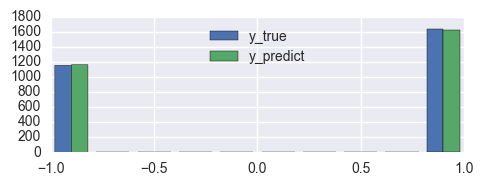

In [84]:
estm = RandomForestClassifier(n_estimators = 50, max_features = None, class_weight = 'balanced')
tuned_parameters = [{'min_samples_split': [2, 3, 5, 7, 10], 'min_samples_leaf': [3, 6, 8, 10, 12]}]

clf = GridSearchCV(estimator=estm, param_grid=tuned_parameters, cv=tscv, scoring=roc_auc_scorer)
clf.fit(Xvar3, Yvar3)

print("Grid ROC AUC scores on development set:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
        % (mean, std, params))
print()
print("Best ROC AUC score is %0.3f." % clf.best_score_, "Best parameters set found on development set:")
print(clf.best_params_)

rf_best_params = clf.best_params_
estm.set_params(**rf_best_params)
estm.fit(Xvar3, Yvar3)
y_true, y_predict = Yvar3, estm.predict(Xvar3)
fg = pt.figure(figsize=(5,2))
pt.hist([y_true, y_predict])
pt.legend(labels = ['y_true', 'y_predict'], loc = 9)
pt.tight_layout()
pt.show()

### Parameters estimation for MLP Classifier (Deep Learning)

In [100]:
n_features = len(SelectedFeatures2)
num_hidden_neurons = mt.floor((0.5*len(Xvar3.index))/(2*(n_features+1)))
hidden_layers = []
for i in range(1,6):
    hidden_layers.append((n_features,)*i)
for i in range(1,6):
    tpl = ()
    for j in range(1,i+1):
        tpl = tpl + (n_features - mt.floor(j*(n_features + 1)/(i+1)),)
    hidden_layers.append(tpl)
print(hidden_layers)

[(23,), (23, 23), (23, 23, 23), (23, 23, 23, 23), (23, 23, 23, 23, 23), (11,), (15, 7), (17, 11, 5), (19, 14, 9, 4), (19, 15, 11, 7, 3)]


Grid ROC AUC scores on development set:
0.533 (+/-0.013) for {'hidden_layer_sizes': (23,)}
0.515 (+/-0.009) for {'hidden_layer_sizes': (23, 23)}
0.539 (+/-0.029) for {'hidden_layer_sizes': (23, 23, 23)}
0.541 (+/-0.014) for {'hidden_layer_sizes': (23, 23, 23, 23)}
0.520 (+/-0.020) for {'hidden_layer_sizes': (23, 23, 23, 23, 23)}
0.525 (+/-0.014) for {'hidden_layer_sizes': (11,)}
0.518 (+/-0.011) for {'hidden_layer_sizes': (15, 7)}
0.547 (+/-0.022) for {'hidden_layer_sizes': (17, 11, 5)}
0.528 (+/-0.011) for {'hidden_layer_sizes': (19, 14, 9, 4)}
0.523 (+/-0.016) for {'hidden_layer_sizes': (19, 15, 11, 7, 3)}

Best ROC AUC score is 0.547. Best parameters set found on development set:
{'hidden_layer_sizes': (17, 11, 5)}


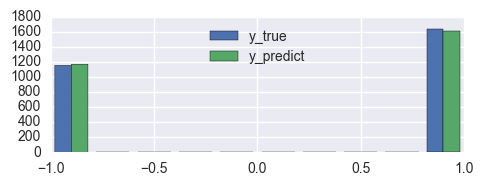

In [101]:
estm = MLPClassifier(activation = 'tanh', solver='lbfgs', shuffle = False)

tuned_parameters = [{'hidden_layer_sizes': hidden_layers}]

clf = GridSearchCV(estimator=estm, param_grid=tuned_parameters, cv=tscv, scoring=roc_auc_scorer)
clf.fit(Xvar3, Yvar3)

print("Grid ROC AUC scores on development set:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
        % (mean, std, params))
print()
print("Best ROC AUC score is %0.3f." % clf.best_score_, "Best parameters set found on development set:")
print(clf.best_params_)

mlp_best_params = clf.best_params_
estm.set_params(**mlp_best_params)
estm.fit(Xvar3, Yvar3)
y_true, y_predict = Yvar3, estm.predict(Xvar3)
fg = pt.figure(figsize=(5,2))
pt.hist([y_true, y_predict])
pt.legend(labels = ['y_true', 'y_predict'], loc = 9)
pt.tight_layout()
pt.show()

##### Conclusion: Several models, such as SVM, SGD and GB, demonstrate the highest ROC AUC of roughly 0.58 - 0.59.
##### I recommend to combine these three classifiers into a Voting Classifier, since the latter may have a lower variance while maintaining the same or better accuracy.

### Defining extended Voting Classifier with a custom probability threshold

In [102]:
class ExtendedVotingClassifier(VotingClassifier):
    def __init__(self, estimators, voting='hard', weights=None, n_jobs=1):
        super(ExtendedVotingClassifier, self).__init__(estimators=estimators, voting=voting, weights=weights, n_jobs=n_jobs)

    def predict_tr(self, X, threshold):
        if ((threshold < 0) or (threshold > 1)):
            raise ValueError('Error: threshold must be in the interval [0,1]')
       
        else:
            probas = self.predict_proba(X)     

            if (probas.shape[1] != 2):
                raise ValueError('Error: predict_tr is only defined for binary classification')
                
            else:
                pclass = max(self.classes_)
                nclass = min(self.classes_)
                pclass_pos = np.where(self.classes_ == pclass)[0][0]
                
                p_proba = probas[: , pclass_pos]
                classifier = lambda x: pclass if x >= threshold else nclass
                class_func = np.vectorize(classifier)
                y_pred = class_func(p_proba)
                
                return y_pred

### Parameters estimation for Voting Classifier

Grid ROC AUC scores on development set:
0.594 (+/-0.050) for {'weights': [0.33, 0.33, 0.33]}
0.590 (+/-0.053) for {'weights': [0.5, 0.25, 0.25]}
0.594 (+/-0.050) for {'weights': [0.25, 0.5, 0.25]}
0.594 (+/-0.050) for {'weights': [0.25, 0.25, 0.5]}
0.594 (+/-0.050) for {'weights': [0.2, 0.4, 0.4]}
0.594 (+/-0.050) for {'weights': [0.4, 0.2, 0.4]}
0.586 (+/-0.057) for {'weights': [0.4, 0.4, 0.2]}
0.585 (+/-0.058) for {'weights': [0.5, 0.333, 0.167]}
0.594 (+/-0.050) for {'weights': [0.5, 0.167, 0.333]}
0.585 (+/-0.058) for {'weights': [0.333, 0.5, 0.167]}
0.594 (+/-0.050) for {'weights': [0.167, 0.5, 0.333]}
0.594 (+/-0.050) for {'weights': [0.167, 0.333, 0.5]}
0.594 (+/-0.050) for {'weights': [0.333, 0.167, 0.5]}

Best ROC AUC score is 0.594. Best parameter found on development set:
{'weights': [0.33, 0.33, 0.33]}


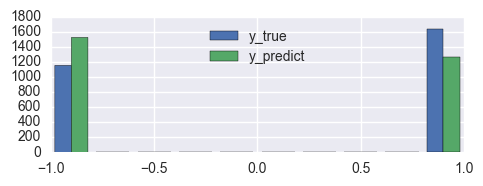

In [141]:
estm1 = SGDClassifier(loss = 'modified_huber', penalty='elasticnet', shuffle = False, n_iter = 100, class_weight = 'balanced')
estm1.set_params(**sgd_best_params)

estm2 = svm.SVC(kernel = 'sigmoid', class_weight = 'balanced', probability = True)
estm2.set_params(**svm_best_params)

estm3 = GradientBoostingClassifier(n_estimators = 50)
estm3.set_params(**gb_best_params)

Vot_estm = ExtendedVotingClassifier(voting = 'soft', estimators=[('sgd', estm1), ('svm', estm2), ('gb', estm3)])
tuned_parameters = [{'weights': [[0.33, 0.33, 0.33], [0.5, 0.25, 0.25], [0.25, 0.5, 0.25], [0.25, 0.25, 0.5],
                                [0.2, 0.4, 0.4], [0.4, 0.2, 0.4], [0.4, 0.4, 0.2], [0.5, 0.333, 0.167], [0.5, 0.167, 0.333],
                                 [0.333, 0.5, 0.167], [0.167, 0.5, 0.333], [0.167, 0.333, 0.5], [0.333, 0.167, 0.5]]}]
clf = GridSearchCV(estimator=Vot_estm, param_grid=tuned_parameters, cv=tscv, scoring=roc_auc_scorer)
clf.fit(Xvar3, Yvar3)

print("Grid ROC AUC scores on development set:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
        % (mean, std, params))
print()
print("Best ROC AUC score is %0.3f." % clf.best_score_, "Best parameter found on development set:")
print(clf.best_params_)

vt_best_params = clf.best_params_
Vot_estm.set_params(**vt_best_params)
Vot_estm.fit(Xvar3, Yvar3)
y_true, y_predict = Yvar3, Vot_estm.predict(Xvar3)
fg = pt.figure(figsize=(5,2))
pt.hist([y_true, y_predict])
pt.legend(labels = ['y_true', 'y_predict'], loc = 9)
pt.tight_layout()
pt.show()

### Choosing optimal probability threshold to maximize accuracy rate

In [175]:
threshold_grid = [0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65]

accuracy_scores = dict()
for tr in threshold_grid:
    accuracy_scores.setdefault(tr, [])

for train, validate in tscv.split(Xvar3):
    Vot_estm.fit(Xvar3.iloc[train], Yvar3.iloc[train])
    y_true = Yvar3.iloc[validate]
    
    for tr in threshold_grid:    
        y_predict = Vot_estm.predict_tr(Xvar3.iloc[validate], threshold = tr)
        accuracy_scores[tr].append(accuracy_score(y_true, y_predict))

print("Grid accuracy scores on development set:")
best_score = 0
best_threshold = 0
for tr in threshold_grid:
    avg_score = np.mean(accuracy_scores[tr])
    std_score = np.std(accuracy_scores[tr])
    print("%0.3f (+/-%0.03f) for threshold = %r" % (avg_score, std_score, tr))
    if (avg_score >= best_score):
        best_score = avg_score
        best_threshold = tr
print()
print("Best accuracy score is %0.3f." % best_score, "Best parameter found on development set:")
print('threshold = ', best_threshold)

Grid accuracy scores on development set:
0.582 (+/-0.072) for threshold = 0.35
0.486 (+/-0.120) for threshold = 0.4
0.489 (+/-0.122) for threshold = 0.45
0.489 (+/-0.122) for threshold = 0.5
0.489 (+/-0.122) for threshold = 0.55
0.469 (+/-0.114) for threshold = 0.6
0.438 (+/-0.118) for threshold = 0.65

Best accuracy score is 0.582. Best parameter found on development set:
threshold =  0.35


######  

# 3.1. Analysis of the performance

### Performance on training dataset

In [203]:
Vot_estm.fit(Xvar3, Yvar3)

ExtendedVotingClassifier(estimators=[('sgd', SGDClassifier(alpha=0.42, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.2, learning_rate='optimal',
       loss='modified_huber', n_iter=100, n_jobs=1, penalty='elasticnet',
       power_t=0.5, random_state=None, shuffle=Fals...s=50, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False))],
             n_jobs=1, voting='soft', weights=[0.33, 0.33, 0.33])

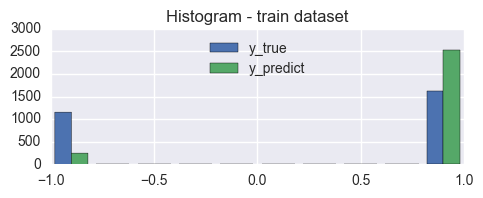


     Confusion matrix - train dataset


,Predicted: down,Predicted: up,Total
Actual: down,154,1000,1154
Actual: up,93,1538,1631
Total,247,2538,2785



True positive rate: 0.943. True negative rate: 0.133.
False positive rate: 0.867. False negative rate: 0.057.

Accuracy rate on the train dataset: 0.608.



In [204]:
y_true, y_predict, y_predict_proba = Yvar3, Vot_estm.predict_tr(Xvar3, best_threshold), Vot_estm.predict_proba(Xvar3)[:,1]

fg = pt.figure(figsize=(5,2))
pt.hist([y_true, y_predict])
pt.legend(labels = ['y_true', 'y_predict'], loc = 9)
pt.tight_layout()
pt.title('Histogram - train dataset')
pt.show()
print()

cm = confusion_matrix(y_true = y_true, y_pred = y_predict, labels = [-1.0, 1.0])
print('     Confusion matrix - train dataset')
table = [["", ' Predicted: down ', ' Predicted: up ', ' Total '],
         [" Actual: down ", cm[0][0], cm[0][1], sum(cm[0,:])],
         [" Actual: up ", cm[1][0], cm[1][1], sum(cm[1,:])],
         [" Total ", sum(cm[:,0]), sum(cm[:,1]), sum(sum(cm))]]
display(HTML(tabulate(table, tablefmt='html')))
print()

fpr, tpr, threshold = roc_curve(y_true = Yvar3, y_score = y_predict, pos_label = 1.0)
Acc_rate = (cm[0][0]+cm[1][1])/sum(sum(cm))
print('True positive rate: %0.3f.' % tpr[1], 'True negative rate: %0.3f.' % (1-fpr[1]))
print('False positive rate: %0.3f.' % fpr[1], 'False negative rate: %0.3f.' % (1-tpr[1]))
print()

print('Accuracy rate on the train dataset: %0.3f.' % Acc_rate)
print()

##### On the training dataset, the model was able to correctly identify 154 - 93 = 61 more outcomes than the passive investment strategy. These outcomes contributed 61 / 2785 = 2.2% to the model's overall accuracy rate of 60.8%. Thus, the model could potentially provide a better accuracy rate than the passive investment strategy, and so generate alpha.
##### Hovewer, the key question is whether this result will be sustained in out-of-sample testing.

### Performance on test dataset (not used in training)

In [205]:
XvarT = TestSetNS[SelectedFeatures2]
YvarT = np.sign(TestSetNS['fwdRet20D'])

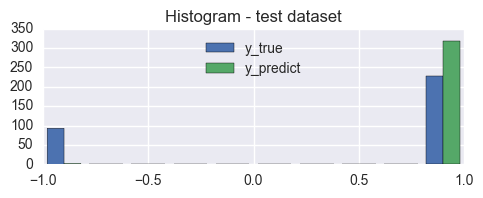


     Confusion matrix - test dataset


,Predicted: down,Predicted: up,Total
Actual: down,2,91,93
Actual: up,0,227,227
Total,2,318,320



True positive rate: 1.000. True negative rate: 0.022.
False positive rate: 0.978. False negative rate: 0.000.

Accuracy rate on the test dataset: 0.716.



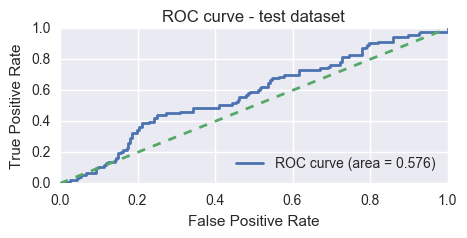

In [206]:
y_true, y_predict, y_predict_proba = YvarT, Vot_estm.predict_tr(XvarT, best_threshold), Vot_estm.predict_proba(XvarT)[:,1]

fg = pt.figure(figsize=(5,2))
pt.hist([y_true, y_predict])
pt.legend(labels = ['y_true', 'y_predict'], loc = 9)
pt.tight_layout()
pt.title('Histogram - test dataset')
pt.show()
print()

cm = confusion_matrix(y_true = y_true, y_pred = y_predict, labels = [-1.0, 1.0])
print('     Confusion matrix - test dataset')
table = [["", ' Predicted: down ', ' Predicted: up ', ' Total '],
         [" Actual: down ", cm[0][0], cm[0][1], sum(cm[0,:])],
         [" Actual: up ", cm[1][0], cm[1][1], sum(cm[1,:])],
         [" Total ", sum(cm[:,0]), sum(cm[:,1]), sum(sum(cm))]]
display(HTML(tabulate(table, tablefmt='html')))
print()

fpr, tpr, threshold = roc_curve(y_true = YvarT, y_score = y_predict, pos_label = 1.0)
Acc_rate = (cm[0][0]+cm[1][1])/sum(sum(cm))
print('True positive rate: %0.3f.' % tpr[1], 'True negative rate: %0.3f.' % (1-fpr[1]))
print('False positive rate: %0.3f.' % fpr[1], 'False negative rate: %0.3f.' % (1-tpr[1]))
print()

print('Accuracy rate on the test dataset: %0.3f.' % Acc_rate)
print()

fprp, tprp, thresholdp = roc_curve(y_true = YvarT, y_score = y_predict_proba, pos_label = 1.0)
score_roc_auc = auc(tprp, fprp)
fg = pt.figure(figsize=(5,2))
pt.plot(tprp, fprp, lw=2, label='ROC curve (area = %0.3f)' % score_roc_auc)
pt.plot([0, 1], [0, 1], lw=2, linestyle='--')
pt.xlabel('False Positive Rate')
pt.ylabel('True Positive Rate')
pt.title('ROC curve - test dataset')
pt.legend(loc="lower right")
pt.show()
print()

##### ROC AUC score on the test dataset is 0.576, falling within the confidence interval obtained during training.
##### Hovewer, the model's accuracy rate has decreased. The model was able to correctly classify just 2 additional data points as compared to a passive long position. Thus, the model's accuracy rate of 71.6% is just 2 / 320 = 0.6% better than that of a passive investment strategy.

######  

# 3.2. Determining most significant features

In [219]:
Unit_X_p = np.matlib.identity(len(XvarT.columns))
Unit_X_n = -1 * Unit_X_p

Res_diff_p = Vot_estm.predict_proba(Unit_X_p)[:,1]
Res_diff_n = Vot_estm.predict_proba(Unit_X_n)[:,1]

Magnitudes = (Res_diff_p - Res_diff_n) / 2
Feature_magnitudes = pd.DataFrame({'Feature': XvarT.columns, 'Magnitude': abs(Magnitudes), 'Sign': np.sign(Magnitudes)})

Feature_magnitudes.sort_values('Magnitude', axis=0, ascending=False, inplace=True)
Feature_magnitudes.iloc[:5]

,Feature,Magnitude,Sign
16,SPX Index MOV_AVG_50D,0.166230,1.0
0,BASPTDSP,0.010484,-1.0
6,GSERMAJ,0.005149,1.0
13,RLABVPTU,0.000442,-1.0
17,SPX Index PCT_MEMB_PX_GT_50D_MOV_AVG,0.000438,-1.0


##### Features with the three highest magnitudes on the model's positive classification probabilitiy are SPX Index MOV_AVG_50D, BASPTDSP and GSERMAJ

######  

# 3.3. Algorithms that performed better on this dataset

##### Most of the considered ML models provided a comparable result, except KNN, which performed notably worse. There is a slight advantage of non-parametric algorithms, such as SVM or GB, over the parametric ones, suggesting that relationship between the features and S&P 500 returns is not linear and distribution of underlying variables is not normal. It is also confirmed by the fact that algorithms with non-linear loss/kernel/activation functions performed better than those with linear ones.
##### Combining several ML models via a Voting Classifier helps to slightly improve results, provided that the underlying models produce uncorrelated predictions on the dataset. This condition is satisfied for SVM, SGD and GB classifiers, which are also 3 top-performing models on the training dataset. Thus, a Voting Classifier performs slightly better than any of these classifiers taken separately.

######  

# 4.1. Ways to improve the model

##### Problem reformulation:
##### -- Rather than trying to forecast returns of S&P 500, it might be better to focus on returns of individual stocks. Decisions are made on the level of individual companies, not indices, so it is more natural to build models for individual stocks than for noisy aggregates like S&P 500. In addition, individual stocks are more volatile due to idiosyncratic risks, thus they provide more opportunities for trading.
##### -- Regression models should be used instead of classification models, as not only direction of S&P 500 matters, but also the magnitude of its change. In particular, if the magnitude of positive movements is on average higher that the magnitude of negative movements, then the cost of false negative predictions is higher than the cost of false positive predictions and the recommended ML model should be completely different.
##### Model estimation:
##### -- Applying more complicated deep learning models, such as convolutional neural networks or deep belief networks, can potentially identify higher-level features that can be used for making more accurate predictions. Likewise, recursive networks or networks with short-term memory can be used to identify intertemporal dependencies among features.
##### -- Chaining of classifiers. More complex estimators can be created by chaining simpler ones, with each estimator in the chain taking output of a preceding estimator as an input. In this case, each estimator in the chain can be tuned to solve some particular subtask where it demonstrates the best performance.
##### -- Probability calibration. Some standard models provide poor estimates of the class probabilities, so it is hard to use them in further analysis. Calibrated classifiers should provide such class probabilities that can be directly interpreted as confidence levels.
##### Feature selection:
##### -- Algorithm specific feature selection. Different ML models can provide better results on different sets of features. Thus, feature selection can be done in a pipeline with the ML model training. This approach might perform better than using the same set of features for training different ML models.
##### -- Feature engineering. New features can be created on the basis of the existing ones. For example, numerical features can be converted into categorical ones or interactions between features can be treated as new variables. 
##### Data mining:
##### -- It is likely that relations among the examined variables was not constant throughout the whole 2001-2014 period. Thus, the dataset should be examined to check whether behavior of the variables was different during different periods. If so, such periods should be treated separately by creating separate ML models for each period. Alternatively, dummy variables can be introduced to account for a perceived change in behavior of variables. For example, most obvious periods that should be accounted for are the financial crisis of 2007–2008 and the periods of presidential elections.
##### -- Finding more data. For example, new variables can be introduced by analyzing the frequency of mentioning key words about the economic sentiment, such as “recession” or “slowdown”, in the major news publications.
##### -- Exploring the nature of outliers. Instead of simply dropping all outliers by a cut off rule, they could be examined and tested. Algorithms like anomaly detection can be used to identify outliers and then it can be decided on a case by case basis whether these outliers make sense or should be dropped.
